- 사람의 활동을 인식하는 1D CNN(1차원 컨볼루션 신경망)을 구축하고 학습시키는 데 사용
- 주요 단계: 데이터 전처리, 모델 구성, 학습 및 평가, 결과 시각화

# **1. 라이브러리 임포트**

In [18]:
import tensorflow as tf # TensorFlow를 사용하여 딥러닝 모델 구축 및 학습
import numpy as np # NumPy로 수치 연산을 수행
import matplotlib.pyplot as plt # 결과를 시각화

# **2. 데이터 파싱 및 전처리**

In [19]:
def parse_end(s):
    try:
        return float(s[-1])
    except:
        return np.nan

> - 입력 문자열의 마지막 값을 추출하여 `float`으로 변환, 만약 변환이 실패하면 `NaN`을 반환

In [20]:
# columns: 'user', 'activity', 'timestamp', 'x-accl', 'y-accl', 'z-accl';
def read_data(file_path):
    labels = {'Walking': 0, 
              'Jogging': 1, 
              'Upstairs': 2, 
              'Sitting': 3, 
              'Downstairs': 4, 
              'Standing': 5}
    data = np.loadtxt(file_path, 
                      delimiter=",", 
                      usecols=(0,1,3,4,5),
                      converters={1: lambda name: labels[name.decode()], 5: parse_end})
    data = data[~np.isnan(data).any(axis=1)]
    return data

> - 이 함수는 CSV 파일에서 데이터를 읽어오고, 특정 열(`user`, `activity`, `x-accl`, `y-accl`, `z-accl`)만 선택
> - `activity` 컬럼의 문자열 값을 `labels` 딕셔너리를 이용해 정수로 변환
> - `NaN` 값을 포함하는 행을 제거한 후, 전처리된 데이터를 반환

# **3. 데이터 로드 및 정규화**

In [21]:
data = read_data("./DATA/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt")

mean = np.mean(data[:,2:], axis=0)
std = np.std(data[:,2:], axis=0)
data[:,2:] = (data[:,2:] - mean) / std

> - `read_data` 함수를 사용해 데이터를 불러온 후, `x`, `y`, `z` 가속도 데이터를 정규화 함

# **4. 데이터 분할 및 세그먼트화**

- 신호 처리에서 주로 사용하는 방법
- 원시 데이터를 일정한 길이의 "세그먼트"로 나누고, 각각의 세그먼트를 모델에 입력할 수 있는 형식으로 변환하는 과정
- 이 과정은 시계열 데이터를 처리할 때 매우 중요한 단계
- 세그먼터(Segment): 데이터를 일정한 길이로 자른 부분, 각 세그먼트는 일정한 시간 동안의 데이터 포인트를 포함하며, 이 경우 `TIME_PERIODS`라는 변수로 세그먼트의 길이를 정의
- 스템 거리(STEP_DISTANCE): 세그먼트를 자를 때 겹치는 부분을 얼마나 유지할지를 결정하는 값, 이 값을 통해 데이터의 중복이 결정됨
- 원-핫 인코딩(One-Hot Encoding): 다중 클래스 레이블을 이진 벡터로 변환하는 방법, ex) 6개의 클래스가 있다면 각 클래스는 길이 6의 벡터에서 하나의 값만 1이고 나머지는 0인 벡터로 표시

In [24]:
x_train = data[data[:,0] <= 28] #[28, 36]
x_test = data[data[:,0] > 28]

> - 사용자 ID를 기준으로 데이터를 훈련 데이터(`x_train`)와 테스트 데이터(`x_test`)로 나눔

In [23]:
TIME_PERIODS = 80 # 1초 동안 80개의 데이터 포인터가 나타남
STEP_DISTANCE = 40 # 세그먼트를 생성할 때 40개의 데이터 포인트마다 세그먼트를 시작하도록 설정

#4. 데이터 세그먼트화 및 라벨링 (-1, TIME_PERIODS, 3)
def data_segments(data):
    segments = []
    labels = []
    for i in range(0, len(data) - TIME_PERIODS, STEP_DISTANCE): #  데이터를 순차적으로 80개씩 잘라내며, 시작점을 40개씩 이동
        X = data[i:i+TIME_PERIODS, 2:].tolist() # 세그먼트 내의 데이터를 슬라이싱하여 리스트로 변환

        # 해당 세그먼트 내의 활동 라벨들을 확인하고, 각각의 라벨이 몇 번 나타나는지를 계산
        values, counts = np.unique(data[i:i+TIME_PERIODS, 1], return_counts=True)
        # 가장 빈번하게 나타나는 활동 라벨을 이 세그먼트의 대표 라벨로 지정
        label = values[np.argmax(counts)]
        
        segments.append(X)
        labels.append(label)

    # reshape (-1, TIME_PERIODS, 3)
    # -1은 자동으로 배열의 첫 번째 차원을 결정, 두 번째 차원은 TIME_PERIODS(세그먼트 길이)이고, 세 번째 차원은 3개의 가속도 축(x, y, z)을 나타냄
    segments = np.array(segments, dtype=np.float32).reshape(-1, TIME_PERIODS, 3) # 세그먼트를 NumPy 배열로 변환하고, 이 배열을 `reshape`함
    labels = np.asarray(labels)
    return segments, labels

> - 데이터를 `TIME_PERIODS` 만큼의 길이로 세그먼트화하고, 세그먼트 내에서 가장 빈번한 활동으로 라벨링
> - 최종적으로 `(세그먼트 수, TIME_PERIODS, 3)` 형태의 데이터 배열과 라벨 배열을 반환
> - 이유: 신경망에 입력되는 데이터는 (배치 크기, 타임 스템, 피처 수) 형식, `reshape`를 사용해 데이터를 이 형식에 맞게 조정

In [26]:
x_train, y_train = data_segments(x_train)
x_test, y_test = data_segments(x_test)

> - 훈련 데이터와 테스트 데이터를 세그먼트화하여 모델 학습에 사용할 준비를 함

# **5. 라벨 원-핫 인코딩**

In [27]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

> - 라벨 데이터를 원-핫 인코딩하여 다중 클래스 분류가 가능하도록 변환

# **6. 1D CNN 모델 생성**

- 1D CNN 모델은 시계열 데이터나 연속적인 데이터를 처리하는데 매우 효과적
- 각 데이터 포인트 간의 지역적 상관관계를 학습하는 데 주로 사용되며, 특히 시간 축에 따라 패턴을 인식하는 데 유용
- 특히 시간 축에 따라 패턴을 인식하는 데 유용

In [28]:
model = tf.keras.Sequential()
# 모델의 입력 형태를 정의, `TIME_PERIODS`=80 길이의 시계열 데이터를 받고, 각 타임 스템에 대해 3개의 특징(`x-accl`, `y-accl`, `z-accl`)을 처리한다는 것을 의미
model.add(tf.keras.layers.Input(shape=(TIME_PERIODS, 3)))
# 100개의 필터를 사용하여 입력 데이터를 컨볼루션함, 11개의 연속된 데이터 포인트를 대상으로 필터를 적용, 활성화 함수 `ReLU`가 사용
model.add(tf.keras.layers.Conv1D(filters=100, kernel_size=11, activation='relu'))
# 맥스 풀링 층은 컨볼루션 층의 출력에서 가장 큰 값을 추출하여 데이터의 크기를 줄이고, 중요한 특징을 강조, 과적합을 방지하여 계산 효율성 높임
model.add(tf.keras.layers.MaxPool1D())
# 각 배치마다 활성화 값을 정규화하여 학습 과정을 안정화하고 가속화
model.add(tf.keras.layers.BatchNormalization())

# 두 번째 컨볼루션 층은 앞서 추출된 특징을 기반으로 더 작은 범위의 패턴을 학습, 10개의 필터를 사용, 5개의 타임 스텝을 대상으로 필터를 적용
model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=5, activation='relu'))
# 중요한 특징을 강조하며 데이터의 크기를 줄임
model.add(tf.keras.layers.MaxPool1D())
# 학습 과정에서 일부 뉴런을 무작위로 비활성화, rate=0.5는 전체 뉴련의 50%를 드롭아웃, 과적합을 방지하고, 모델이 특정 뉴런에 지나치게 의존하지 않도록 함
model.add(tf.keras.layers.Dropout(rate=0.5))

# 다차원 배열을 일차원으로 변환, 완전 연결 층(Dense Layer)에 데이터를 전달하기 위해 필요한 전처리 단계, 시계열 데이터를 벡터 형태로 변환
model.add(tf.keras.layers.Flatten())
# 6개의 뉴런을 가진 완전 연결층, `softmax`활성화 함수를 사용해 출력값을 다중 클래스 확률로 변환, 모델의 예측을 결정함
model.add(tf.keras.layers.Dense(units=6, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                │ (None, 70, 100)         │        3,400 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling1d (MaxPooling1D)   │ (None, 35, 100)         │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ batch_normalization            │ (None, 35, 100)         │          400 │
│ (BatchNormalization)           │                         │              │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ conv1d_1 (Conv1D)              │ (None, 31, 10)          │        5,010 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling1d_1 (MaxPooling1D) │ (None, 15, 10)          │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dropout (Dropout)              │ (None, 15, 10)          │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ flatten (Flatten)              │ (None, 150)             │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense (Dense)                  │ (None, 6)               │          906 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 9,716 (37.95 KB)

 Trainable params: 9,516 (37.17 KB)

 Non-trainable params: 200 (800.00 B)

**히든 레이어(은닉층)의 역할**
- 컨볼루션 층과 맥스 풀링 층은 모델의 히든 레이어 역할을 함 
- 히든 레이어는 입력 데이터에서 점점 더 높은 수준의 특징을 학습하도록 도와줌
- 각 히든 레이어는 이전 레이어의 출력에서 중요한 패턴을 학습하며, 이 패턴들이 쌓여 최종적으로 데이터의 분류를 수행하는 데 필요한 복잡한 특징을 학습
 > - 컨볼루션 층: 입력 데이터의 국소적인 패턴을 학습
 > - 맥스 풀링 층: 이 패턴에서 중요한 부분을 선택하고, 데이터의 크기를 줄여 다음 층에서 효율적으로 처리
 > - 배치 정규화 층: 학습 과정을 안정화하고 가속화
 > - 드롭아웃 층: 과적합을 방지하여 모델의 일반화 성능을 향상
- 히든 레이어들을 통해 모델은 입력 데이터를 점진적으로 높은 수준의 특징으로 변환하며, 마지막에는 이 특징들을 기반으로 입력 데이터의 클래스(활동)를 예측

# **7. 모델 컴파일 및 학습**

In [31]:
# RMSprop (Root Mean Square Propagation) 옵티마이저
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, batch_size=400,
               validation_data=(x_test, y_test), verbose=2)

Epoch 1/100
53/53 - 5s - 102ms/step - accuracy: 0.6235 - loss: 1.3124 - val_accuracy: 0.5272 - val_loss: 1.3405
Epoch 2/100
53/53 - 4s - 69ms/step - accuracy: 0.7295 - loss: 0.7288 - val_accuracy: 0.6739 - val_loss: 1.0938
Epoch 3/100
53/53 - 3s - 63ms/step - accuracy: 0.7563 - loss: 0.6166 - val_accuracy: 0.5293 - val_loss: 1.6130
Epoch 4/100
53/53 - 3s - 65ms/step - accuracy: 0.8034 - loss: 0.5100 - val_accuracy: 0.6428 - val_loss: 1.3745
Epoch 5/100
53/53 - 4s - 67ms/step - accuracy: 0.8501 - loss: 0.4705 - val_accuracy: 0.7485 - val_loss: 0.9446
Epoch 6/100
53/53 - 3s - 64ms/step - accuracy: 0.8807 - loss: 0.3633 - val_accuracy: 0.7464 - val_loss: 1.2955
Epoch 7/100
53/53 - 3s - 66ms/step - accuracy: 0.8909 - loss: 0.3455 - val_accuracy: 0.7257 - val_loss: 0.9908
Epoch 8/100
53/53 - 4s - 73ms/step - accuracy: 0.8957 - loss: 0.3146 - val_accuracy: 0.8316 - val_loss: 1.0873
Epoch 9/100
53/53 - 4s - 68ms/step - accuracy: 0.9069 - loss: 0.2806 - val_accuracy: 0.7868 - val_loss: 0.9039


> - 모델을 RMSprop 옵티마이저와 교차 엔트로피 손실 함수로 컴파일하고, 훈련 데이터로 모델을 학습

# **8. 모델 평가**

In [33]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

653/653 - 1s - 2ms/step - accuracy: 0.9610 - loss: 0.1269
206/206 - 0s - 2ms/step - accuracy: 0.8173 - loss: 1.4130


> - 훈련 데이터와 테스트 데이터에 대해 모델의 성능을 평가함

# **9. 정확도 및 손실 시각화**

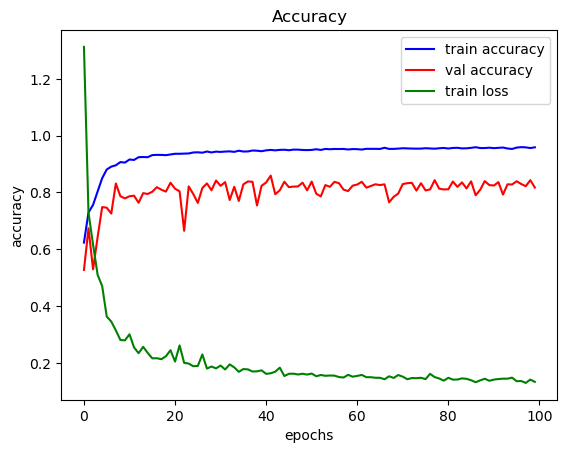

In [35]:
plt.title("Accuracy")
plt.plot(ret.history['accuracy'], "b-", label="train accuracy")
plt.plot(ret.history['val_accuracy'], "r-", label="val accuracy")
plt.plot(ret.history['loss'], "g-", label="train loss")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc="best")
plt.show()

> - 학습 과정에서의 정확도와 손실을 시각화하여 모델 성능을 분석

# **10. 샘플 활동 데이터 시각화**

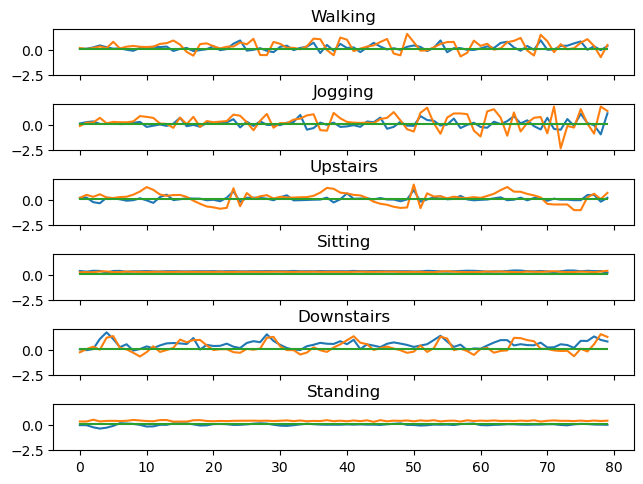

In [37]:
activity = ('Walking', 'Jogging', 'Upstairs', 'Sitting', 'Downstairs', 'Standing')
train_label = np.argmax(y_train, axis=1)

plot_data = []
n = 1
for i in range(6):
    plot_data.append(np.where(train_label == i)[0][n])

fig, ax = plt.subplots(6, sharex=True, sharey=True)
fig.tight_layout()
for i in range(6):
    k = plot_data[i]
    ax[i].plot(x_train[k], label=activity[i])
    ax[i].set_title(activity[i])
plt.show()

> - 각 활동에 대한 샘플 데이터를 시각화하여 모델이 학습한 결과를 확인